In [1591]:
#Dependencies
import graspy
import pdb
import myModule
from mgcpy.independence_tests.mgc import MGC
from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.independence_tests.rv_corr import RVCorr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import random
%matplotlib inline
from graspy.simulations import sbm
from graspy.plot import heatmap
np.random.seed(10)

#Generating simulation/test data
def data_generator(num_graphs, N, ss_N, p_0, p_1, percent_0,  percent_1):
    
    #Create empty tensor for data to be added to,
    #as well as tensors to store each data type
    num_0 = int(num_graphs * percent_0)
    num_1 = int(num_graphs * percent_1)
    type_0 = np.zeros((num_graphs,N,N))
    type_1 = np.zeros((num_graphs,N,N))
    data = np.zeros((num_graphs,N,N))
    p_data = np.zeros((num_graphs,N,N))
    y_label = np.zeros((1,num_graphs))
    n = [ss_N, N - ss_N]
    
    #This creates test data
    L_ind = random.sample(range(0, num_graphs), num_graphs)
    
    for i in range(len(data)):
        type_0[i] = sbm(n=n, p=p_0)
        type_1[i] = sbm(n=n, p=p_1)
    
    type_0[L_ind[num_0:]] = np.zeros((N, N))
    type_1[L_ind[:num_0]] = np.zeros((N, N))
    
    data[L_ind[:num_0]] = type_0[L_ind[:num_0]]
    data[L_ind[num_0:]] = type_1[L_ind[num_0:]]
    
    y_label[0,L_ind[:num_0]] = 0
    y_label[0,L_ind[num_0:]] = 1
    y_label = y_label.astype(int)
    y_label = y_label[0]
    
    type_0 = type_0[L_ind[:num_0]]
    type_1 = type_1[L_ind[num_0:]]
    
    p_data[L_ind[num_0:],:ss_N,:ss_N] = p_0[0][0]
    p_data[L_ind[num_0:],:ss_N,ss_N:] = p_0[0][1]
    p_data[L_ind[num_0:],ss_N:,:ss_N] = p_0[1][0]
    p_data[L_ind[num_0:],ss_N:,ss_N:] = p_0[1][1]
    p_data[L_ind[:num_0],:ss_N,:ss_N] = p_1[0][0]
    p_data[L_ind[:num_0],:ss_N,ss_N:] = p_1[0][1]
    p_data[L_ind[:num_0],ss_N:,:ss_N] = p_1[1][0]
    p_data[L_ind[:num_0],ss_N:,ss_N:] = p_1[1][1]
    
    data_0 = np.subtract(np.power(p_data, data), p_data)
    data_1 = np.multiply(data, p_data)
    prob_data = data_0 + data_1
    prob_data_0 = prob_data[L_ind[num_0:]]
    prob_data_1 = prob_data[L_ind[:num_0]]
    
    p_tensor = np.zeros((2, N, N))
    mat_0 = np.zeros((N, N))
    mat_0[:ss_N,:ss_N] = p_0[0][0]
    mat_0[:ss_N,ss_N:] = p_0[0][1]
    mat_0[ss_N:,:ss_N] = p_0[1][0]
    mat_0[ss_N:,ss_N:] = p_0[1][1]
    p_tensor[0] = mat_0
    mat_1 = np.zeros((N, N))
    mat_1[:ss_N,:ss_N] = p_1[0][0]
    mat_1[:ss_N,ss_N:] = p_1[0][1]
    mat_1[ss_N:,:ss_N] = p_1[1][0]
    mat_1[ss_N:,ss_N:] = p_1[1][1]
    p_tensor[1] = mat_1
    
    
    return type_0, type_1, data, prob_data, prob_data_0, prob_data_1, y_label, p_tensor

def classifier_method(num_graphs, N, percent_0, percent_1, tensor_0, tensor_1, ss_m_n, A):
    ones = np.ones(N)
    A_complement = ones - A
    
    num_0 = (percent_0 * num_graphs)
    num_1 = (percent_1 * num_graphs)
    
    #frac_0 = (num_0)**(-1)
    #frac_1 = (num_1)**(-1)
    
    #p_hat_0 = np.multiply(np.sum(tensor_0, axis=0), frac_0)
    #p_hat_1 = np.multiply(np.sum(tensor_1, axis=0), frac_1)
    #p_hat_0_complement = ones - p_hat_0
    #p_hat_1_complement = ones - p_hat_1
    
    tensor_0_complement = ones - tensor_0
    tensor_1_complement = ones - tensor_1
    
    prod_0 = np.multiply(np.power(tensor_0[ss_m_n], A[ss_m_n]), np.power(tensor_0_complement[ss_m_n], A_complement[ss_m_n]))
    #print(prod_0)
    prod_1 = np.multiply(np.power(tensor_1[ss_m_n], A[ss_m_n]), np.power(tensor_1_complement[ss_m_n], A_complement[ss_m_n]))
    #print(prod_0[ss_m_n])
    prob_0 = np.prod(prod_0)
    prob_1 = np.prod(prod_1)
    
    val = float((percent_0 / percent_1) * np.prod(np.true_divide(prod_0, prod_1)))
    
    #class_prob_0 = percent_0 * prob_0
    #class_prob_1 = percent_1 * prob_1
    #val = float(class_prob_0 / class_prob_1)
    if val >= 1.0:
        label = 0
    else:
        label = 1
    
    #print(val)
    return label
    
def non_iterative_screen(a_tensor, N, y_labels, c, opt):

    '''
    Performs iterative screening on graphs.

    Parameters

    ----------
    
    a_tensor: tensor of adjacency matrices that are going to be used for signal subgraph.

    mat_n_m: Length/width of the adjacency matrices in the dictionary
    
    y_labels: the vector of labels.
    
    c: the correlation threshold value.
    
    opt: indicator of whether to use dcorr or mgc

    Returns

    -------

    values_flags: the signal subgraph of a_matrix, found through non-iterative

    vertex screening.
    '''
    mgc = MGC()
    dcorr = DCorr(which_test = 'unbiased')
    rvcorr = RVCorr()
    count = len(a_tensor)
    S_hat = np.zeros((count,1))
    
    #Creates matrices by stacking the nth rows on top of each other and running mgc on those with their 
    #corresponding labels.
    for i in range(len(a_tensor)):
        mat = a_tensor[:,i]
        #data[y_label_class[:,0].astype(int)][0]
        if opt == "mgc":
            c_u_0, independence_test_metadata_0 = mgc.test_statistic(mat, y_labels)
            S_hat[i][0] = c_u_0
        elif opt == "dcorr":
            c_u_1, independence_test_metadata_1 = dcorr.test_statistic(mat, y_labels)
            S_hat[i][0] = c_u_1
        else:
            c_u_2, independence_test_metadata_1 = rvcorr.test_statistic(mat, y_labels)
            S_hat[i][0] = c_u_2
    
    S_hat = np.absolute(S_hat)
    S_hat = S_hat[:,0]
    #as_vec = np.sort(S_hat.reshape(1,200)).reshape(200,1)
    #list_comp = as_vec[-20:]
    #values_flags = []
    #for i in range(20):
    #    values_flags.append(np.where(S_hat == list_comp[i])[0][0])
    largest = S_hat.argsort()[-20:][::-1]
    values_flags = np.nonzero(S_hat > c)
    
    return values_flags[0][:] #, largest
    

def iterative_screen(a_tensor, N, y_labels, delta, opt):

    '''
    Performs iterative screening on graphs.

    Parameters

    ----------
    
    a_tensor: tensor of adjacency matrices that are going to be used for signal subgraph.

    mat_n_m: Length/width of the adjacency matrices in the dictionary
    
    y_labels: the vector of labels.
    
    delta: quantile to be screened
    
    opt: indicator of whether to use dcorr or mgc

    Returns

    -------

    values_flags: the signal subgraph of a_matrix, found through non-iterative

    vertex screening.
    '''
    mgc = MGC()
    dcorr = DCorr(which_test = 'unbiased')
    rvcorr = RVCorr()
    count = len(a_tensor)
    S_hat = np.zeros((count,1))
    
    V = np.arange(200)
    
    while V.size > 1:
        c_u_list = []
        for i in V:
            c_u, independence_test_metadata = mgc.test_statistic(a_tensor[:,i], y_labels)
            c_u_list.append(abs(c_u))
        t_k = np.quantile(c_u_list, .50, axis = 0)
        ind = [i for i,j in enumerate(c_u_list) if j > t_k]
        V = V[ind]
        print(V)

    c_k, independence_test_metadata = mgc.test_statistic(a_tensor[:,V[0]], y_labels)
    #k_* = np.argmax()
    
    return V, c_k

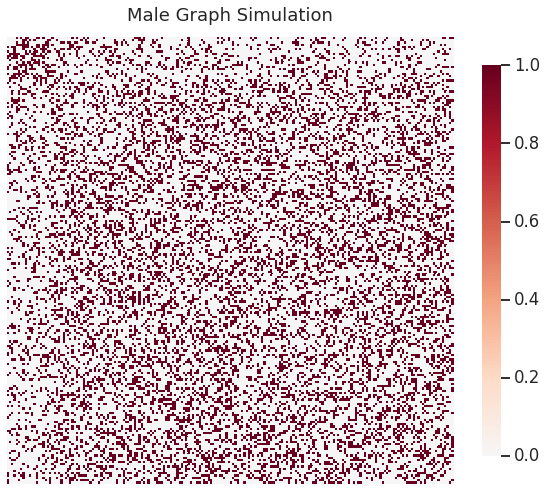

<Figure size 432x288 with 0 Axes>

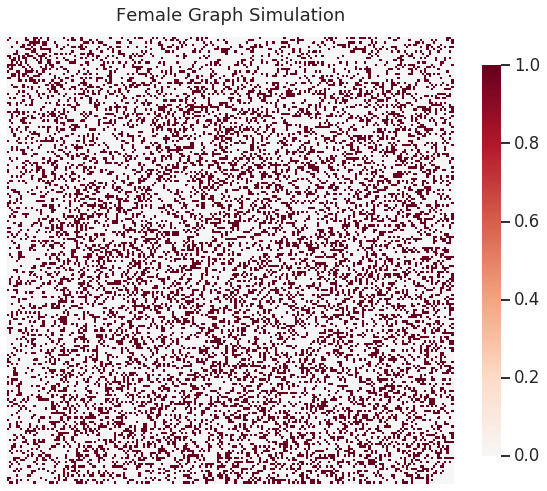

In [1499]:
# Make Simulation Data
p_matrix_female = [[.3, .2], [.2, .3]]
p_matrix_male = [[.4, .2], [.2, .3]]

female, male, data, p_data, p_data_female, p_data_male, y_label, p_types = data_generator(100, 200, 20, p_matrix_female, p_matrix_male, 0.50, 0.50)
y_label_class = y_label.reshape(100,1).astype(float)

# Plot
heatmap(data[0], title='Male Graph Simulation')

plt.figure()
heatmap(data[1], title='Female Graph Simulation')

In [1570]:
import sklearn.metrics as metrics
c = np.linspace(0.03, 0, num=16)
#c = [0.001, 0.005, 0.01, 0.015, 0.020, 0.025]
tensor_labels = np.zeros((16, 1, 100))
counter = 0
for i in c:
    test_labels = []
    ss_m_n = non_iterative_screen(data, 200, y_label_class, i, "mgc")
    for j in range(len(data)):
        test_labels.append(classifier_method(100, 200, .50, .50, p_types[0], p_types[1], ss_m_n, data[j]))
    tensor_labels[counter] = test_labels
    counter += 1
    
#print(s_hat)    
#print(tensor_labels)

[0.        0.7173913 1.       ]
0
[0.         0.73333333 1.        ]
1
[0.         0.83333333 1.        ]
2
[0.         0.83333333 1.        ]
3
[0.         0.83333333 1.        ]
4
[0.    0.925 1.   ]
5
[0.    0.975 1.   ]
6
[0.         0.95555556 1.        ]
7
[0.         0.95555556 1.        ]
8
[0. 1. 1.]
9
[0. 1. 1.]
10
[0. 1. 1.]
11
[0.         0.97727273 1.        ]
12
[0.         0.97727273 1.        ]
13
[0.         0.97619048 1.        ]
14
[0.         0.97727273 1.        ]
15
0.9261363636363636


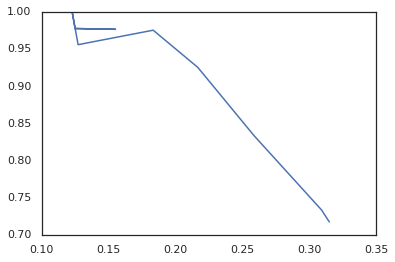

In [1571]:
false_pos_list = []
true_pos_list = []
for i in range(len(tensor_labels)):
    list_test_labels = np.ndarray.tolist(tensor_labels[i][0])
    list_test_labels = [int(i) for i in list_test_labels]
    fpr, tpr, threshold = metrics.roc_curve(list_test_labels, y_label)
    print(tpr)
    print(i)
    false_pos_list.append(fpr[1])
    true_pos_list.append(tpr[1])

print(metrics.auc(fpr, tpr))
plt.plot(false_pos_list, true_pos_list)

In [1592]:
iterative_screen(data, 200, y_label.reshape(100,1), 0.05, "mgc")

[  0   2   4   6   9  10  11  12  13  14  15  16  17  20  21  23  25  26
  29  32  37  38  39  40  48  49  50  54  56  57  59  60  68  70  72  73
  75  76  80  82  84  86  88  89  90  92  93  96  98  99 100 101 102 104
 107 108 110 111 112 113 114 115 117 118 120 126 128 129 131 132 136 137
 138 139 140 143 145 150 152 153 154 155 157 158 159 162 165 167 171 173
 174 178 179 181 185 189 192 194 196 197]
[  0   4   6  10  11  12  13  14  15  17  20  21  26  32  48  60  73  89
  90  92  98  99 100 101 104 107 108 111 113 114 115 118 120 126 129 131
 136 137 145 150 153 155 158 167 173 174 185 192 194 196]
[  0   4  10  11  15  60  73  90  92  99 100 107 111 113 118 126 129 131
 136 137 173 174 185 192 196]
[  0   4  10  15  60  73  90  99 100 111 185 196]
[  0   4  60  90  99 100]
[ 0 90 99]
[0]


(array([0]), 0.06666918141386818)

In [1593]:
non_iterative_screen(data, 200, y_label_class, 0.092, "cca")

array([ 0,  4,  6, 10, 11, 12, 13, 14, 15, 20, 26, 60, 73, 89])

In [1594]:
non_iterative_screen(data, 200, y_label_class, 0.02, "dcorr")

array([ 0,  4, 10, 11, 14, 15, 21, 48, 60, 73, 89, 90, 92])

In [1595]:
non_iterative_screen(data, 200, y_label_class, 0.02, "mgc")

array([ 0,  4, 10, 11, 14, 15, 21, 48, 60, 73, 90, 92, 99])